In [84]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


In [85]:
# Define file paths
file_paths = ['data2/lda/so_new.csv', 'data2/lda/qc.csv', 'data2/lda/cr.csv', 'data2/lda/se.csv']

# Initialize an empty list to store dataframes
dfs = []

# Load and process each file
for file_path in file_paths:
    # Load the dataset
    df = pd.read_csv(file_path)
    
    # Ensure required columns exist
    required_columns = ['Id', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body', 'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'ClosedDate']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"The file {file_path} must contain the column '{col}'.")
    
    # Select only the required columns
    df = df[required_columns]
    
    # Merge Title and Body into a new column 'text'
    df['text'] = df['Title'].fillna('') + ' ' + df['Body'].fillna('')
    
    # Add a new column 'From' based on the file name prefix
    df['From'] = file_path.split('/')[-1].split('.')[0]  # Extract 'so', 'qc', 'cr', or 'se'
    
    # Append to the list
    dfs.append(df)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True)

# Save the merged dataframe to a new CSV file
df.to_csv('data2/merged_data_with_source.csv', index=False)

print("Merged dataframe with 'From' column has been saved as 'merged_data_with_source.csv'.")

Merged dataframe with 'From' column has been saved as 'merged_data_with_source.csv'.


In [3]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /Users/mac/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [86]:
# Preprocessing: Tokenize, remove stopwords, and lowercase
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    return ' '.join([word for word in tokens if word.isalnum() and word not in stop_words])

df['processed_text'] = df['text'].apply(preprocess)

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['processed_text'])

In [88]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# Convert document-term matrix to gensim format
corpus = [doc.split() for doc in df['processed_text']]
id2word = Dictionary(corpus)
bow_corpus = [id2word.doc2bow(text) for text in corpus]

# Fit LDA model
lda_model = LdaModel(
    corpus=bow_corpus,
    id2word=id2word,
    num_topics=20,      # Set k = 20
    alpha=0.01,         # Set alpha = 0.01
    eta=0.02,           # Set beta = 0.02
    random_state=42,    # Set for reproducibility
    passes=10,          # Number of passes through the corpus during training
    iterations=100      # Number of iterations for each pass
)

# Print topics
topics = lda_model.print_topics(num_words=10)
for idx, topic in topics:
    print(f"Topic {idx}: {topic}")


Topic 0: 0.062*"code" + 0.047*"import" + 0.041*"gt" + 0.031*"pre" + 0.024*"p" + 0.021*"print" + 0.020*"qiskit" + 0.016*"qc" + 0.016*"quantumcircuit" + 0.015*"range"
Topic 1: 0.125*"quantum" + 0.056*"hamiltonian" + 0.052*"classical" + 0.033*"p" + 0.032*"problem" + 0.031*"time" + 0.029*"computer" + 0.019*"system" + 0.016*"computers" + 0.014*"computing"
Topic 2: 0.358*"0" + 0.241*"1" + 0.161*"2" + 0.037*"3" + 0.015*"4" + 0.010*"b" + 0.010*"p" + 0.009*"unitary" + 0.007*"matrix" + 0.006*"qreg"
Topic 3: 0.203*"span" + 0.062*"p" + 0.020*"n" + 0.012*"state" + 0.010*"u" + 0.010*"1" + 0.008*"quantum" + 0.008*"h" + 0.008*"states" + 0.007*"unitary"
Topic 4: 0.148*"https" + 0.101*"p" + 0.090*"noreferrer" + 0.087*"nofollow" + 0.046*"img" + 0.037*"image" + 0.035*"description" + 0.033*"enter" + 0.031*"circuit" + 0.011*"gate"
Topic 5: 0.074*"code" + 0.067*"error" + 0.042*"logical" + 0.033*"p" + 0.031*"stabilizer" + 0.028*"codes" + 0.022*"errors" + 0.019*"z" + 0.019*"surface" + 0.017*"correction"
Topic 

In [71]:
# Create output for each topic_distribution
output = []
for topic_id, topic_terms in lda_model.show_topics(num_topics=20, num_words=10, formatted=True):
    # Get topic_distribution keywords
    keywords = topic_terms

    # Get documents relevant to this topic_distribution
    topic_docs = []
    for doc_id, doc_topics in enumerate(lda_model.get_document_topics(bow_corpus)):
        for topic, score in doc_topics:
            if topic == topic_id and score > 0.5:  # Highly relevant threshold
                topic_docs.append((df.loc[doc_id, 'Id'], score))

    # Sort documents by relevance
    topic_docs = sorted(topic_docs, key=lambda x: x[1], reverse=True)

    # Calculate document statistics
    doc_count = len([doc for doc in lda_model.get_document_topics(bow_corpus) if topic_id in [t[0] for t in doc]])
    doc_rate = doc_count / len(df)

    # Create the final row for this topic_distribution
    output.append({
        'index': topic_id,
        'keywords': keywords,
        'documents_count': doc_count,
        'documents_rate': round(doc_rate, 2),
        'documents_highly_relevant': str(topic_docs[:20])  # Top 20 relevant documents
    })

# Convert output to a DataFrame
output_df = pd.DataFrame(output)

# Save the output
output_df.to_csv('data2/topics/topic_summary.csv', index=False)

print("Topic summary has been saved as 'topic_summary.csv'.")

Topic summary has been saved as 'topic_summary.csv'.


In [72]:
# Assign topic_distribution probabilities to each document
df['topics'] = [lda_model.get_document_topics(doc, minimum_probability=0.01) for doc in bow_corpus]

# Save the updated DataFrame
df.to_csv('data2/topics/data_with_topics.csv', index=False)

print("Topics have been added to the DataFrame and saved as 'data_with_topics.csv'.")

Topics have been added to the DataFrame and saved as 'data_with_topics.csv'.


In [73]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
visualization = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
pyLDAvis.display(visualization)

/Users/mac/path/to/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=57008) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mac/path/to/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=57008) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mac/path/to/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=57008) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mac/path/to/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=57008) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/mac/path/to/venv/lib/python3.12/site-packages/joblib/externals/lo

# trend

/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_57008/2170935018.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topics_documents[topic].loc[len(topics_documents[topic].index)] = row
/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_57008/2170935018.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topics_documents[topic].loc[len(topics_documents[topic].index)] = row
/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_57008/2170935018.py:44: FutureWarning: The 

[1713, 1716, 2045, 4228, 2632, 1659, 1140, 2210, 2792, 2867, 1553, 1270, 323, 2216, 3162, 992, 342, 636, 2757, 1822]


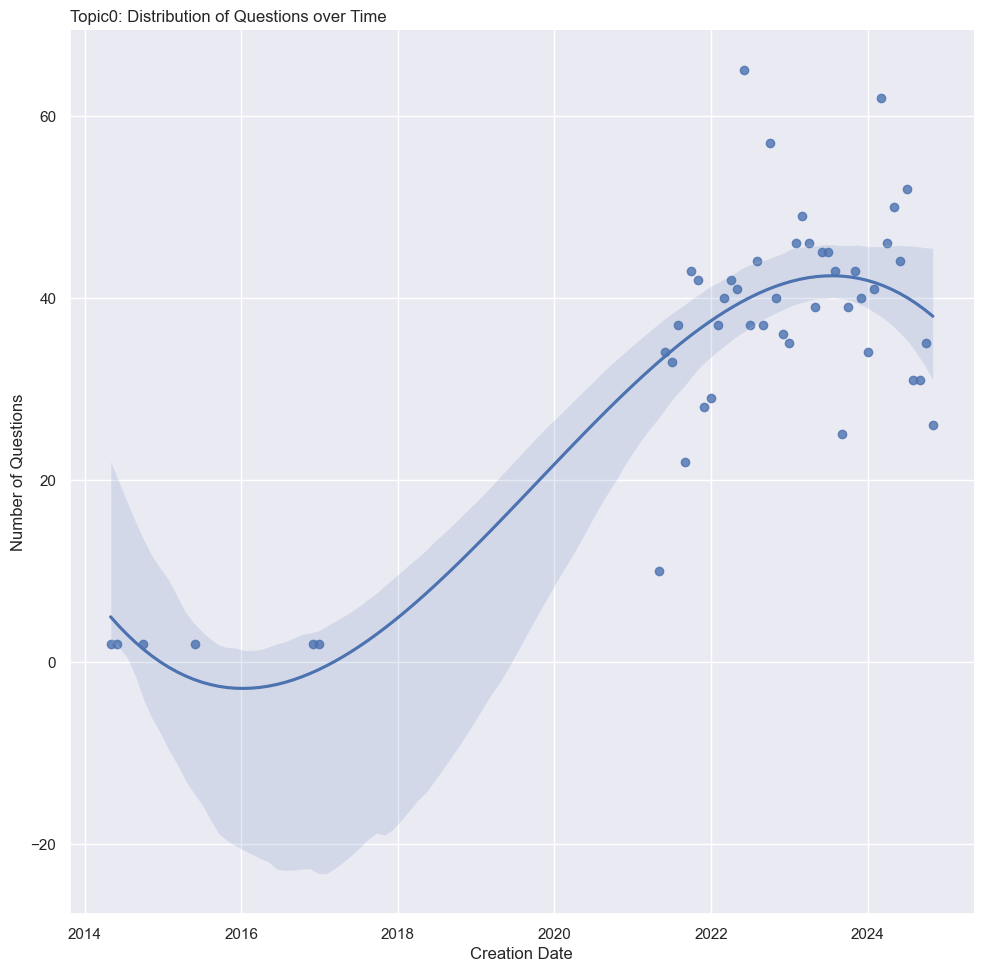

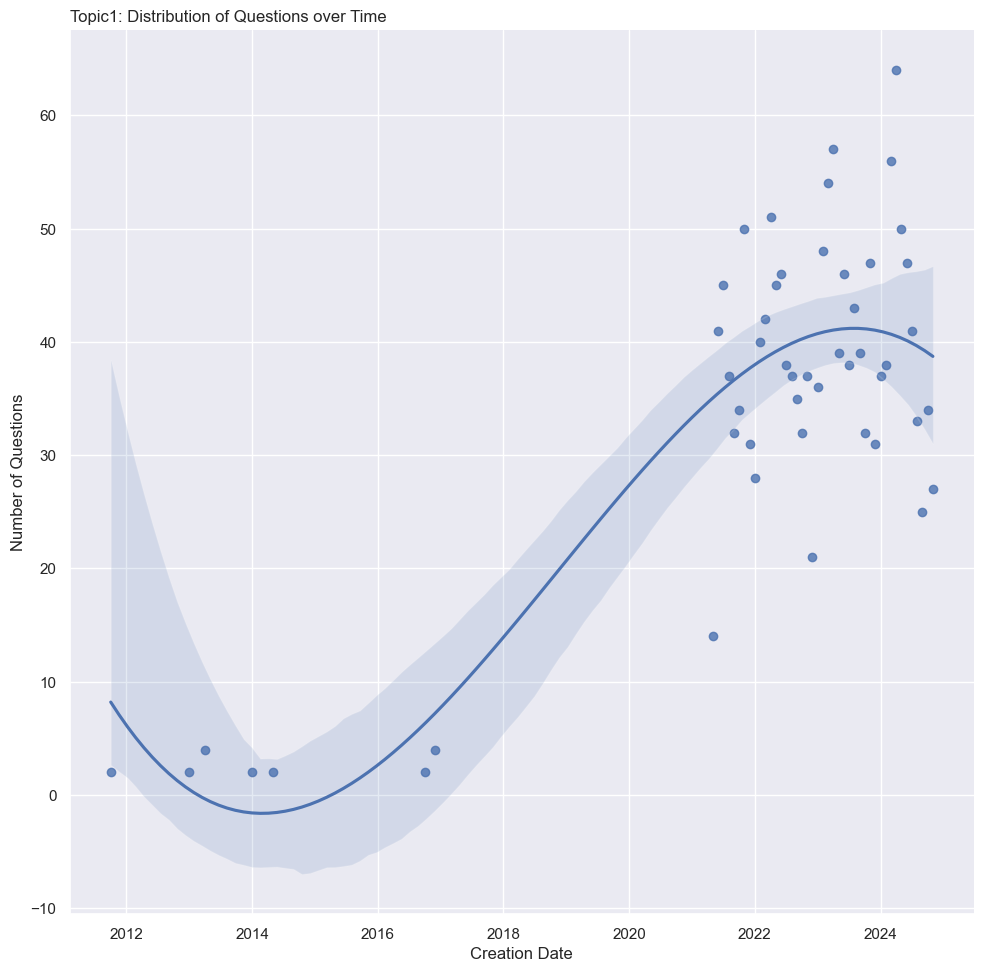

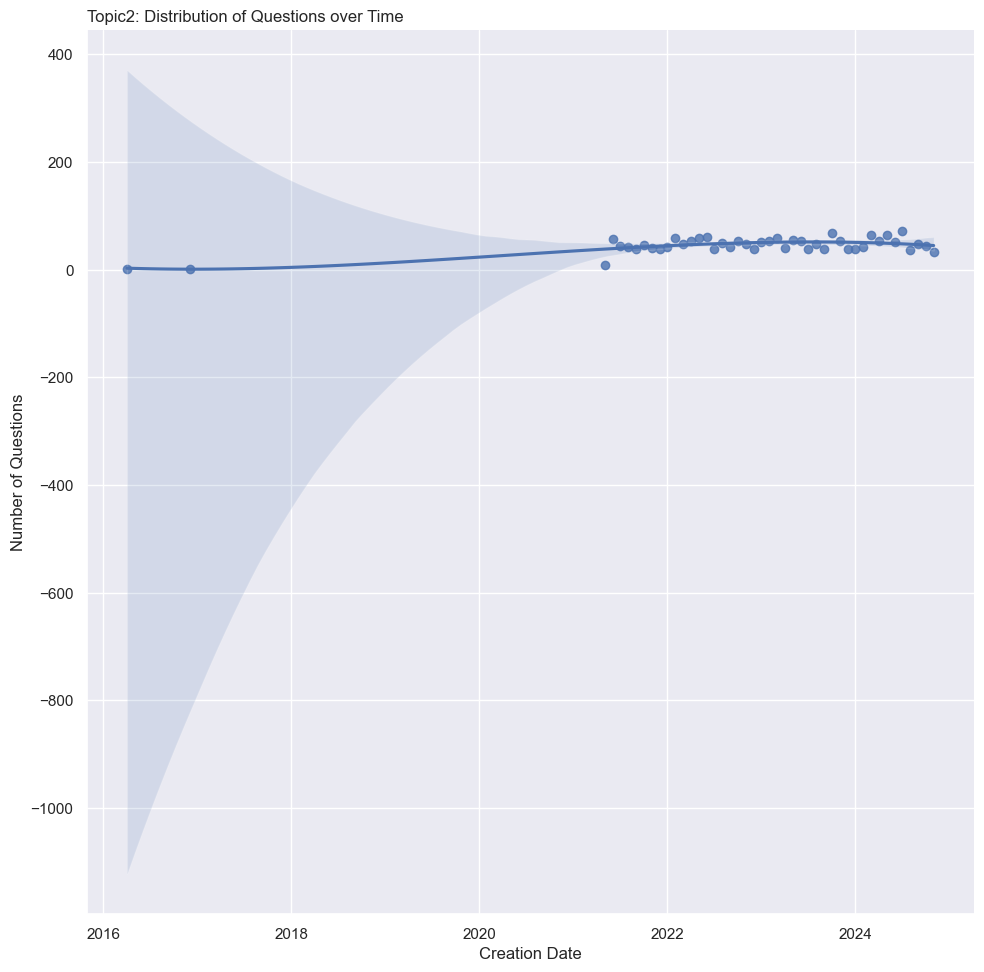

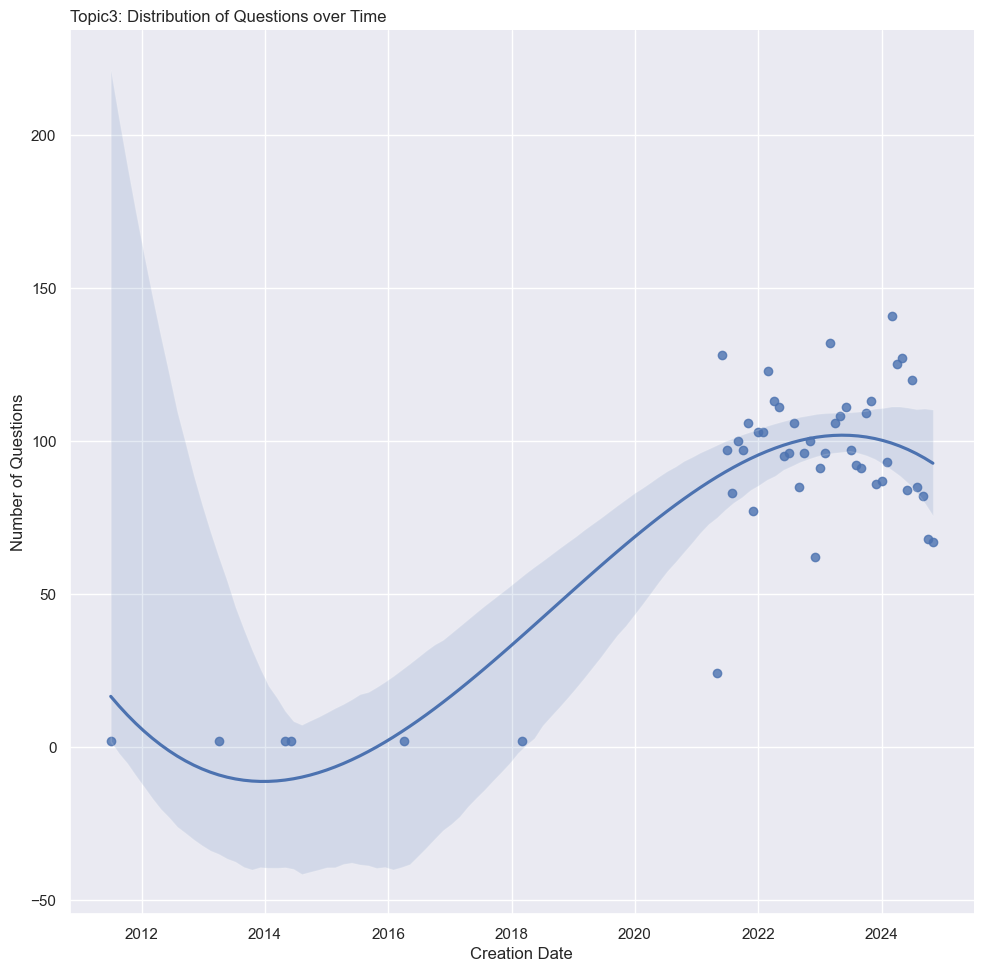

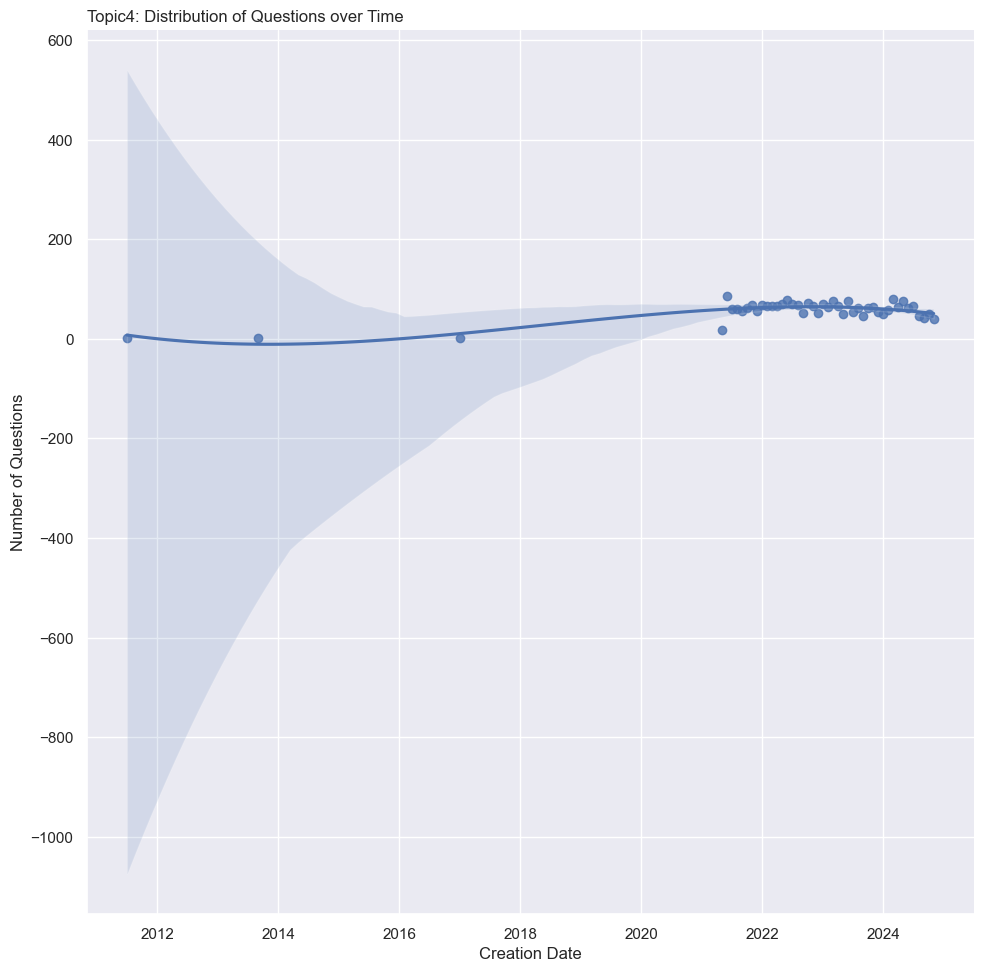

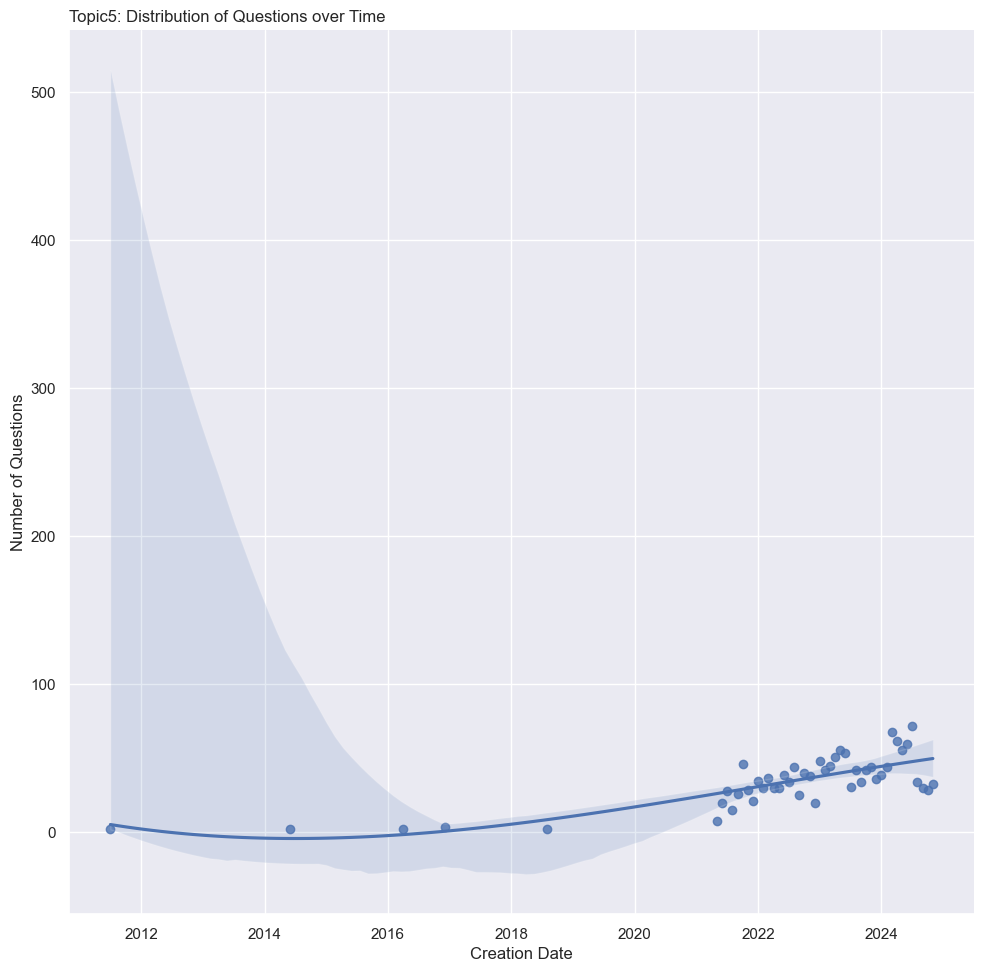

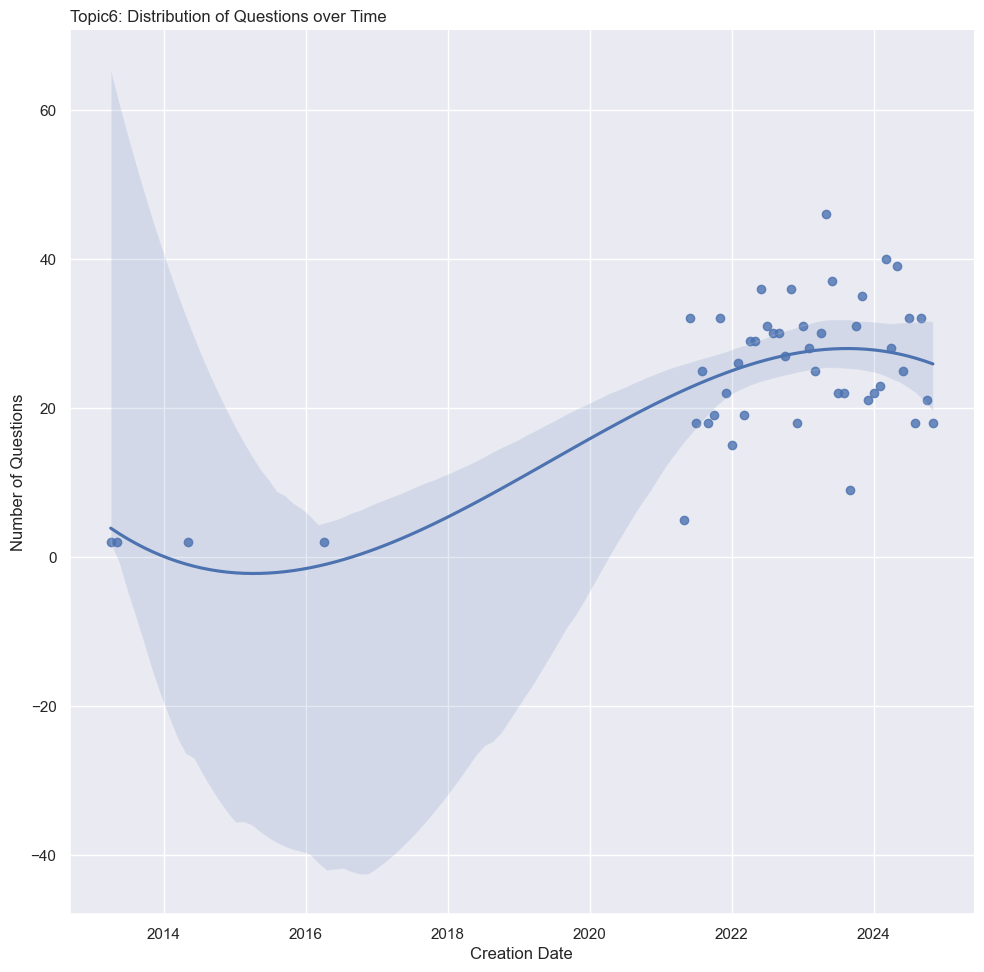

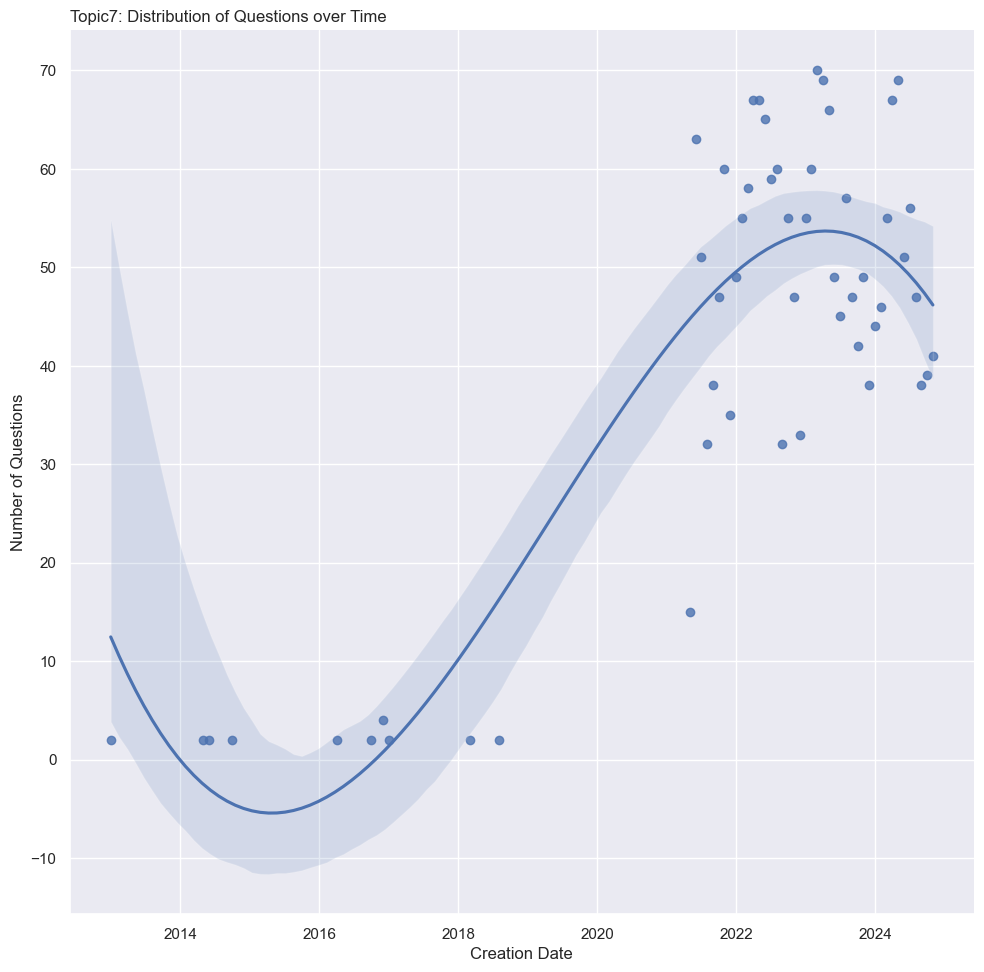

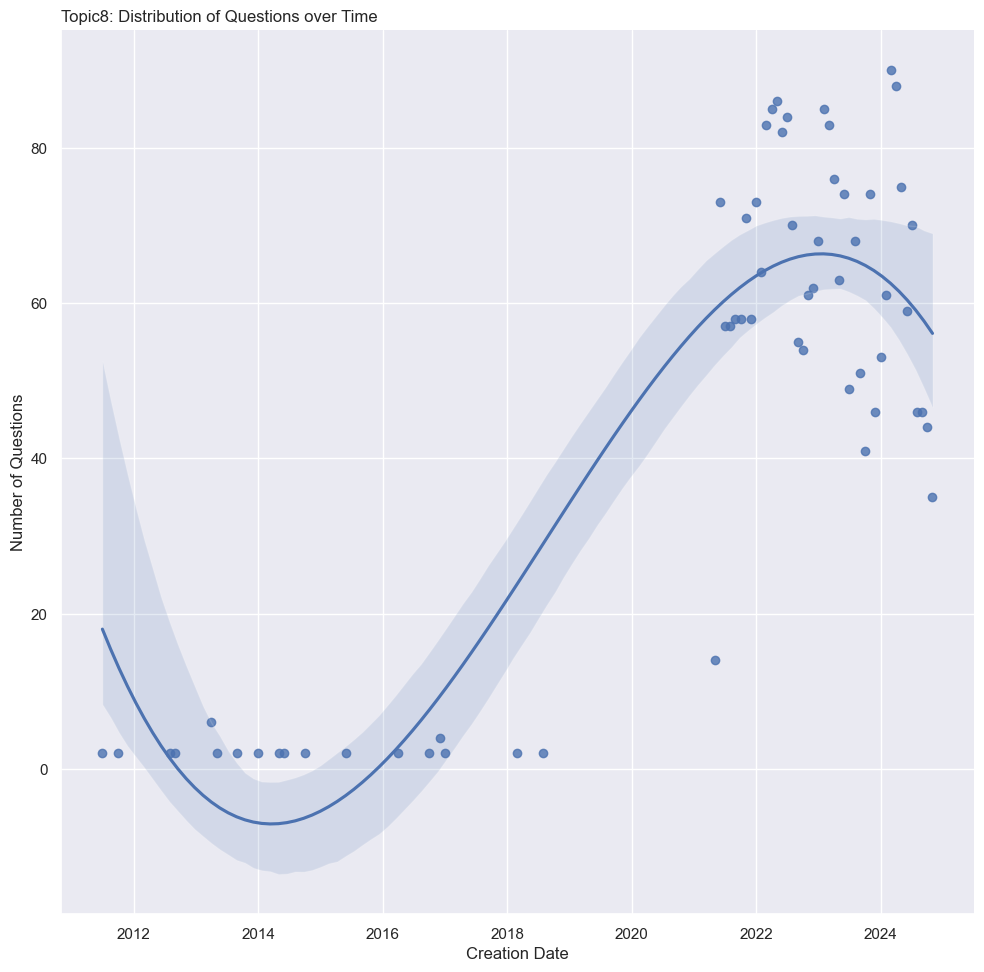

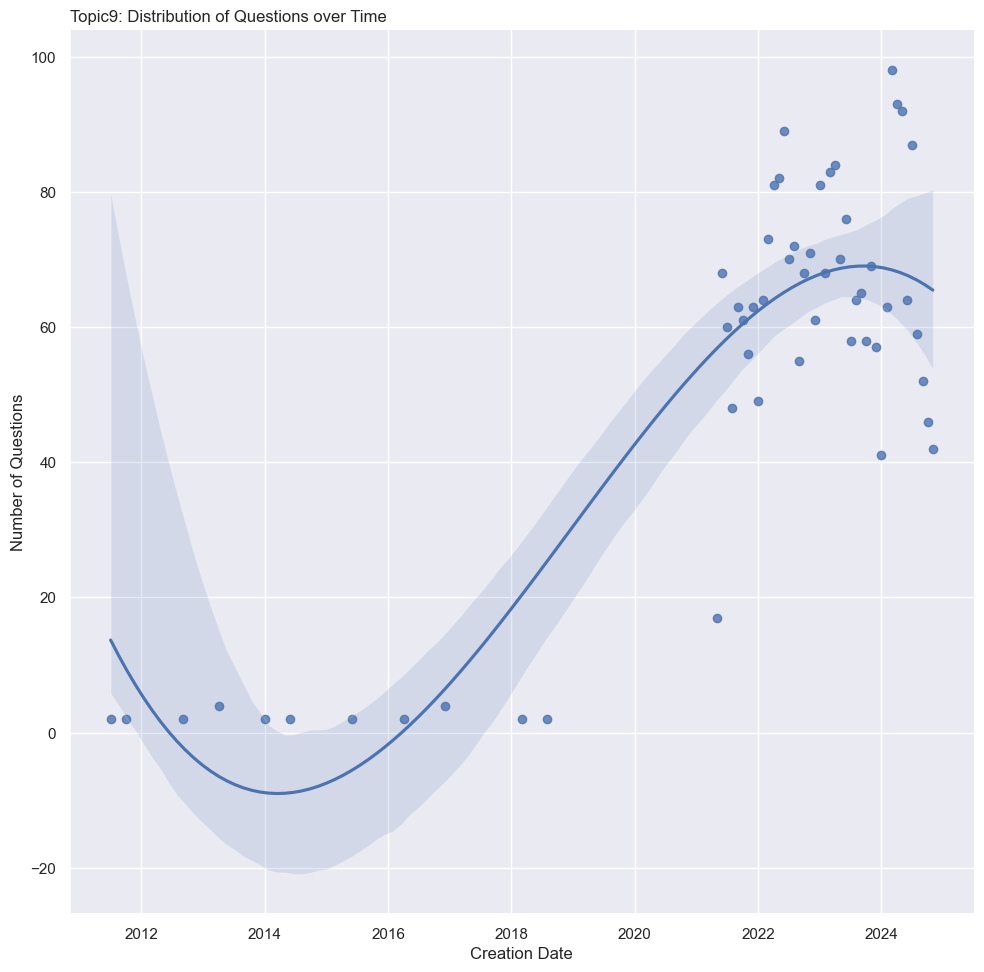

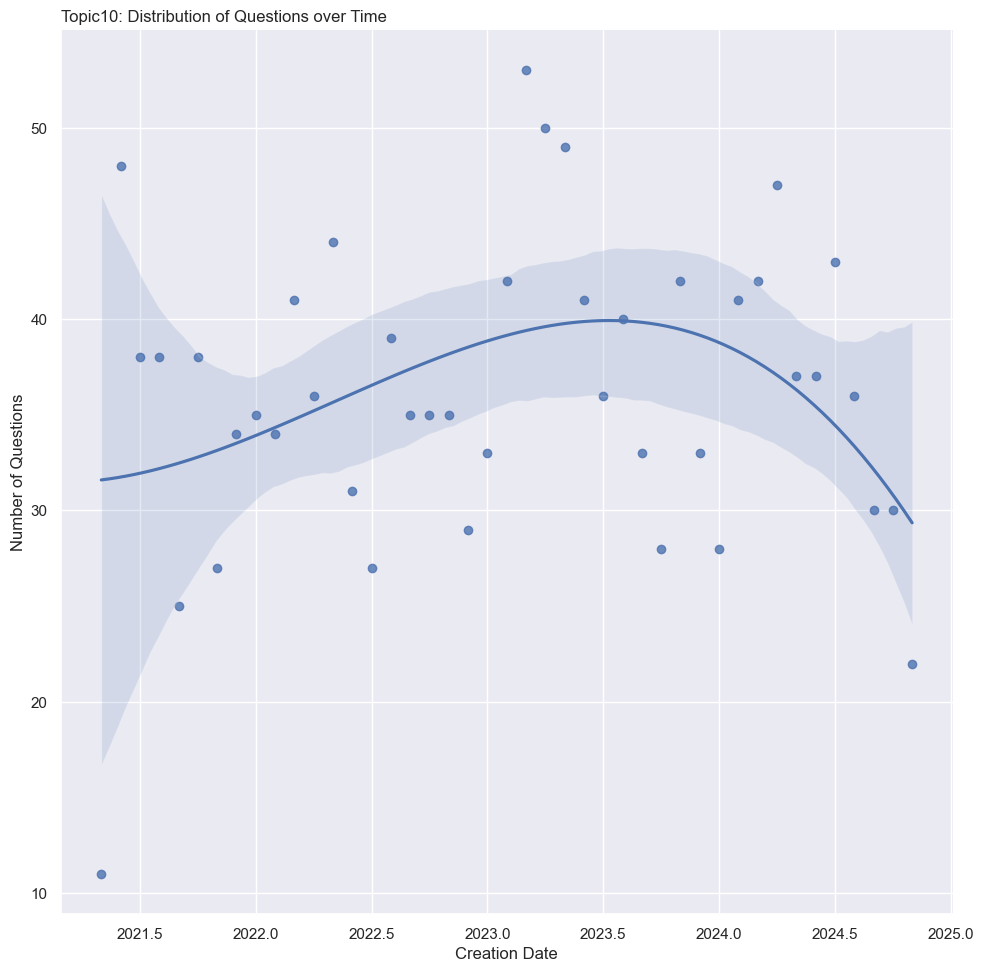

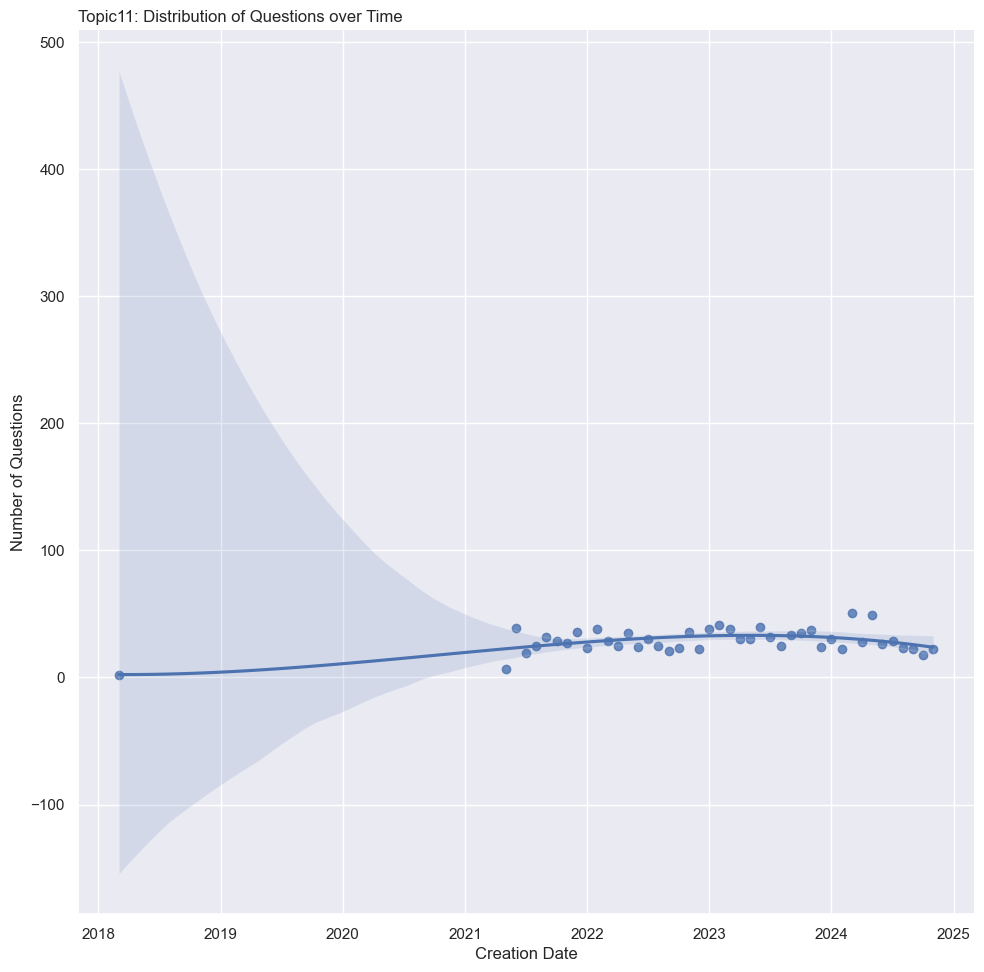

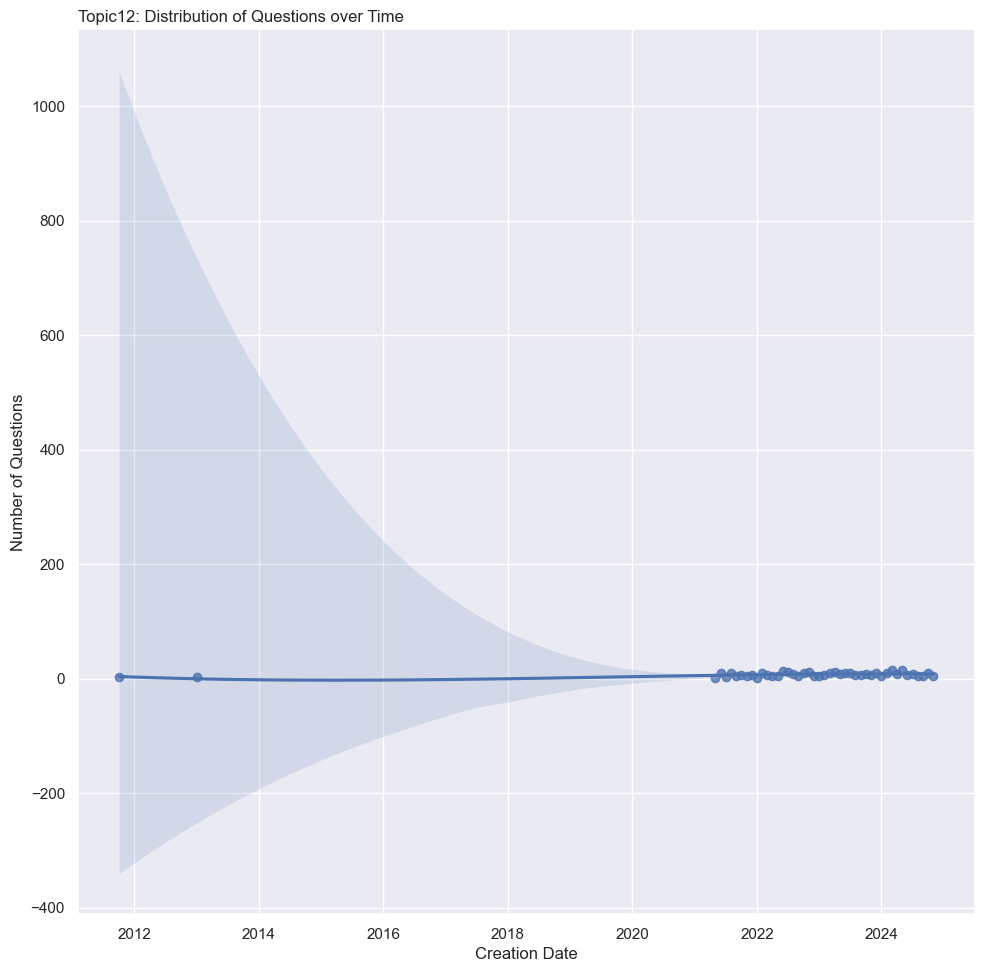

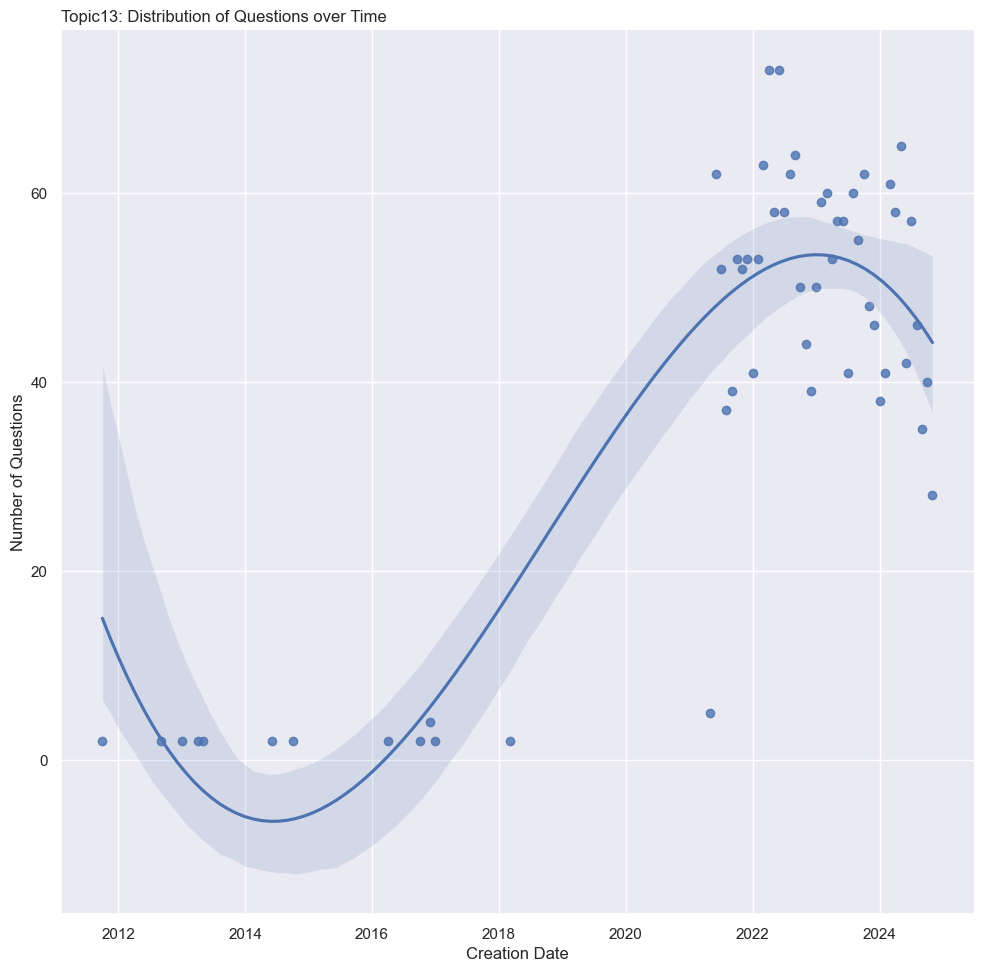

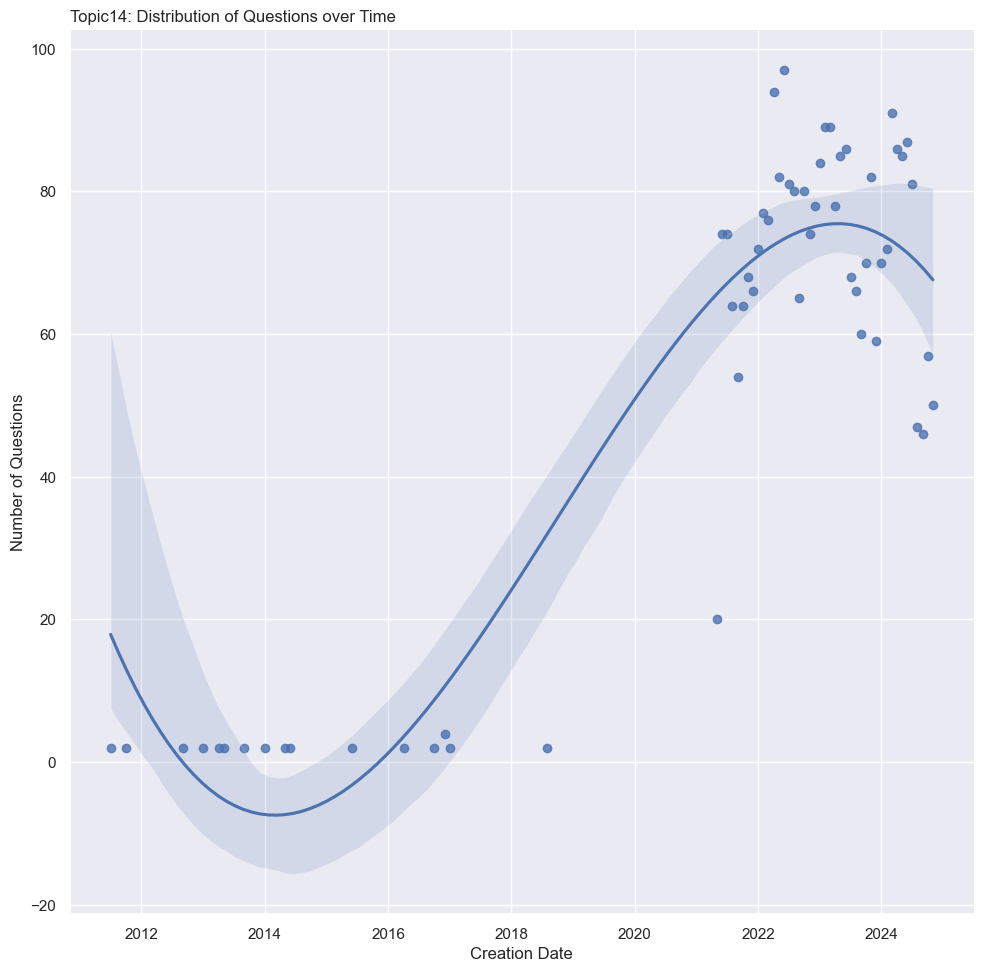

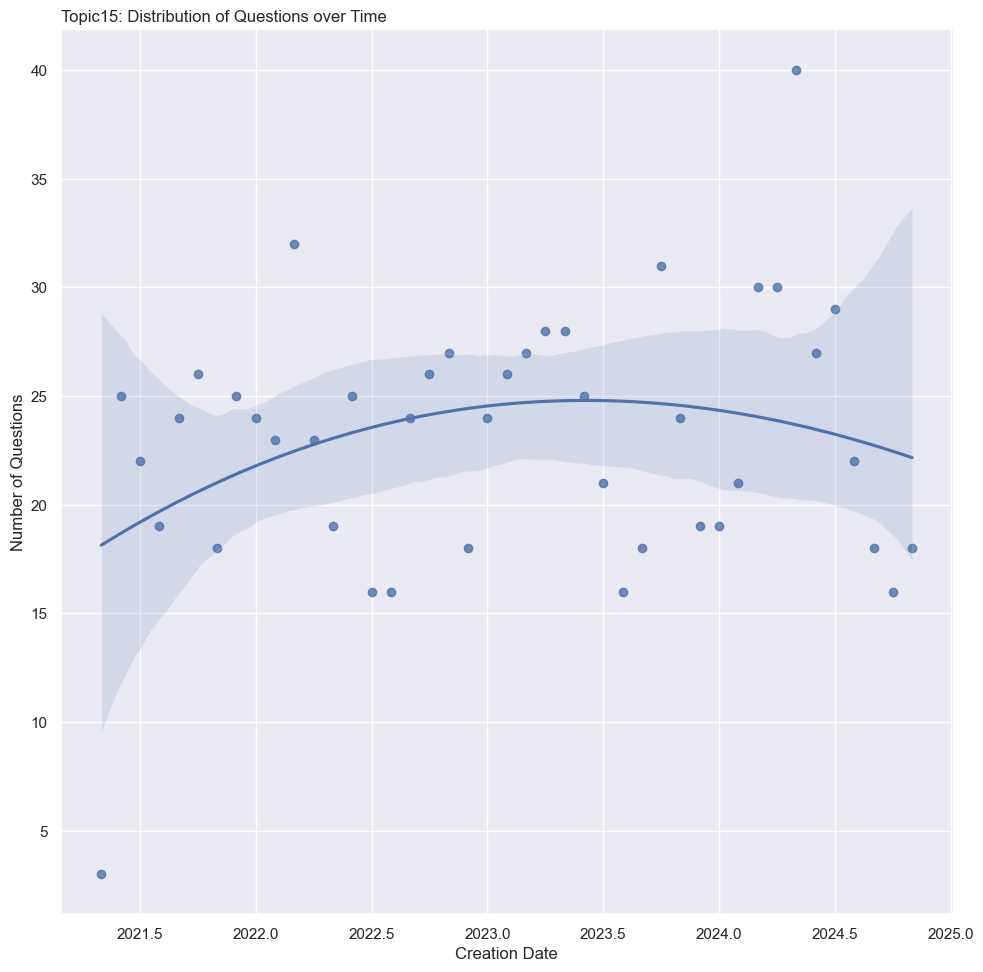

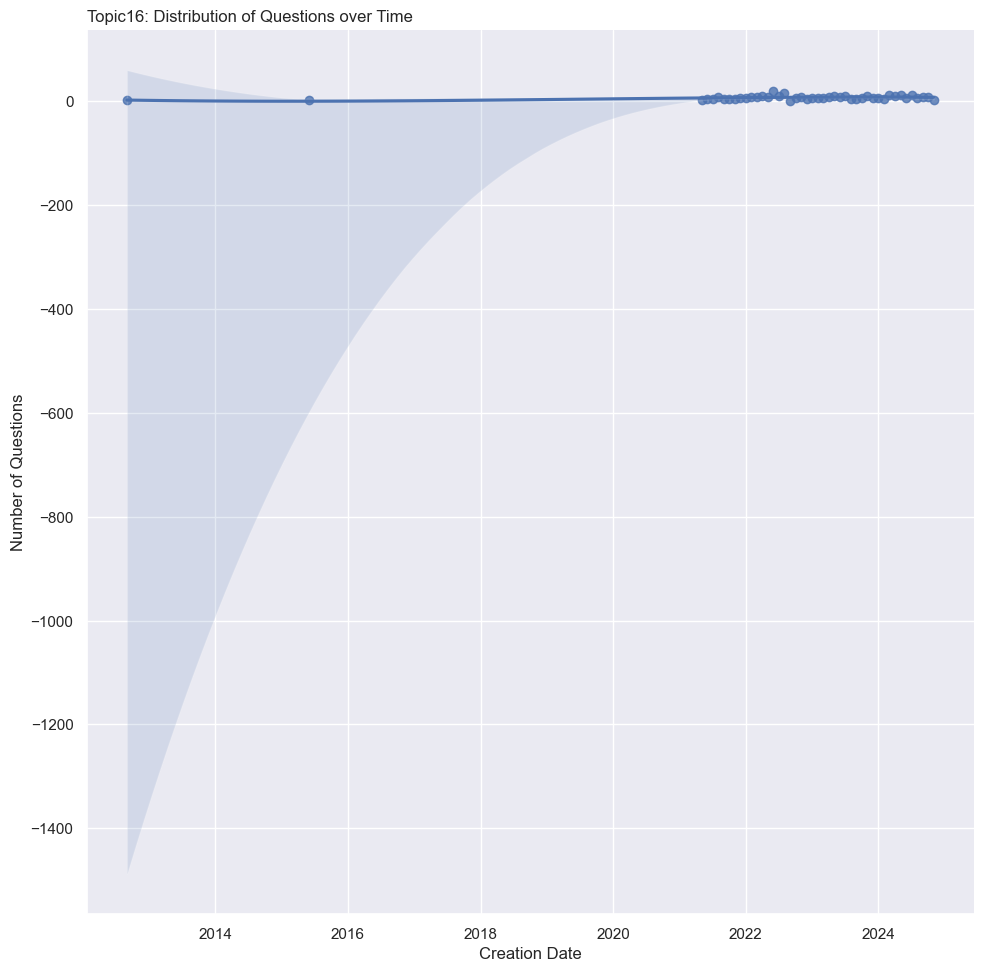

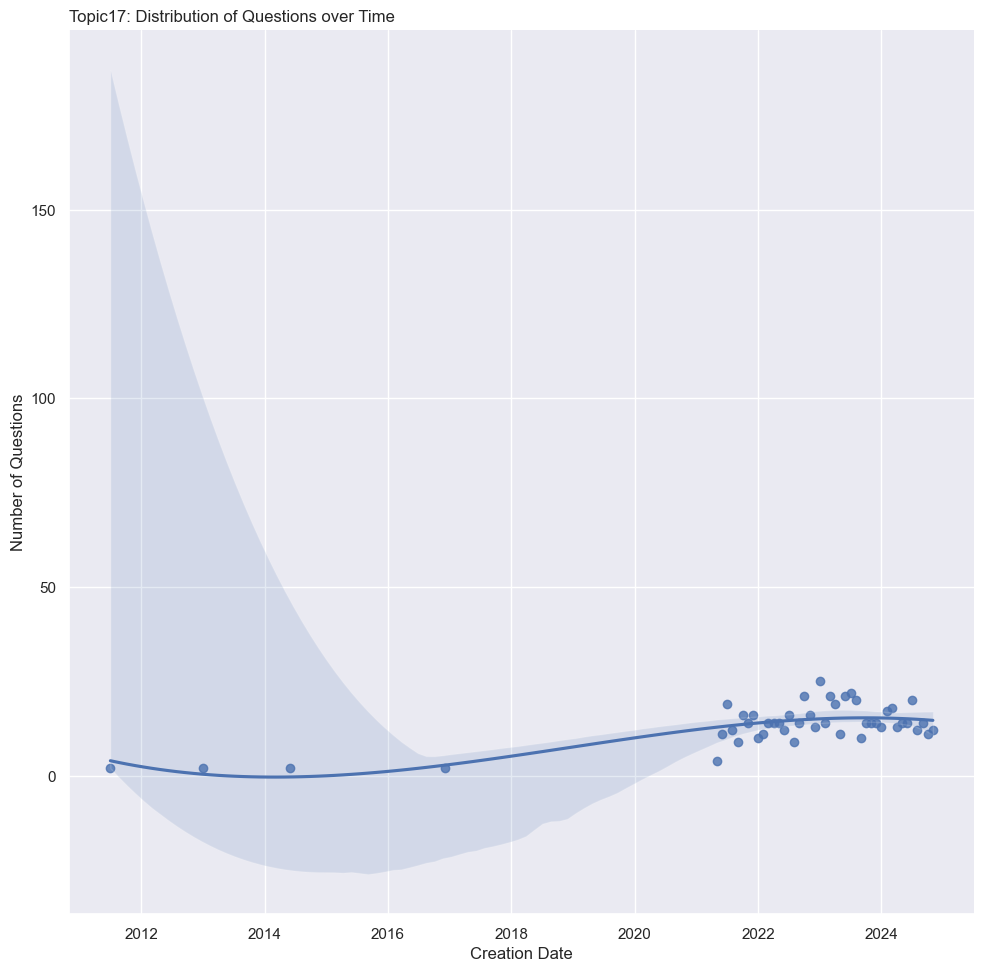

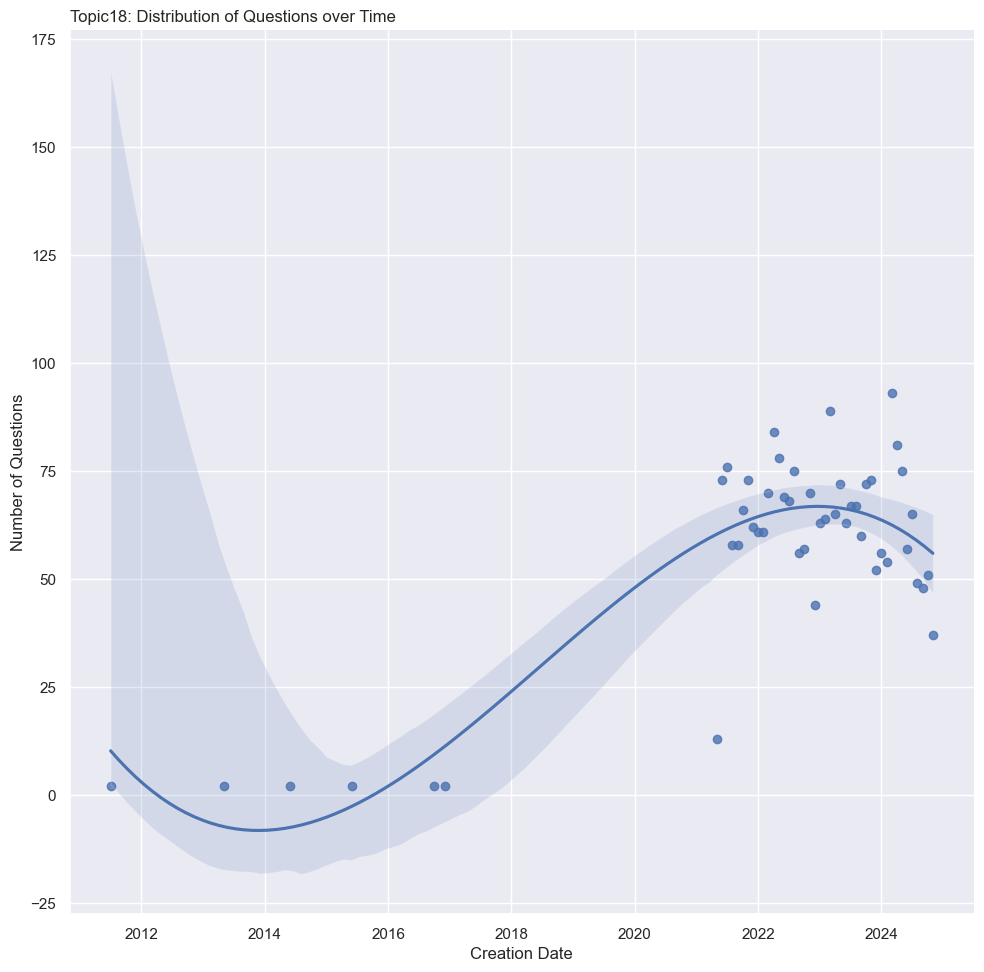

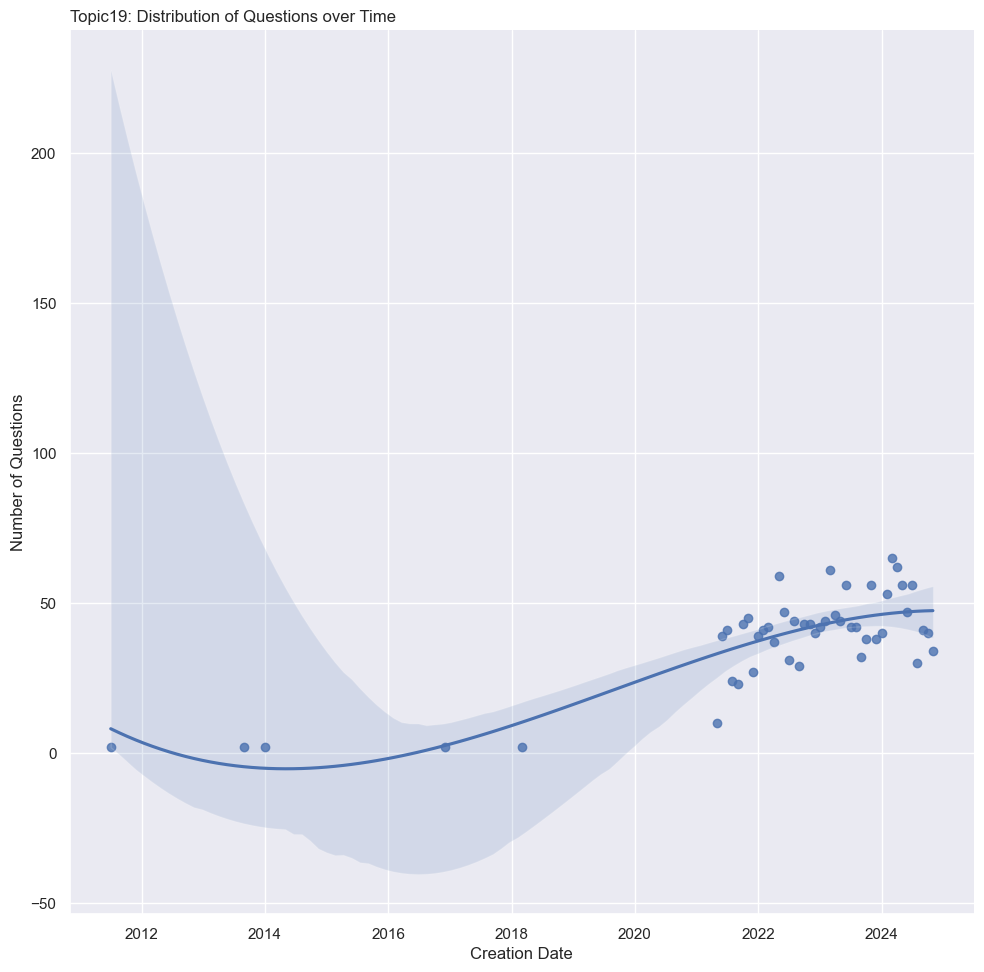

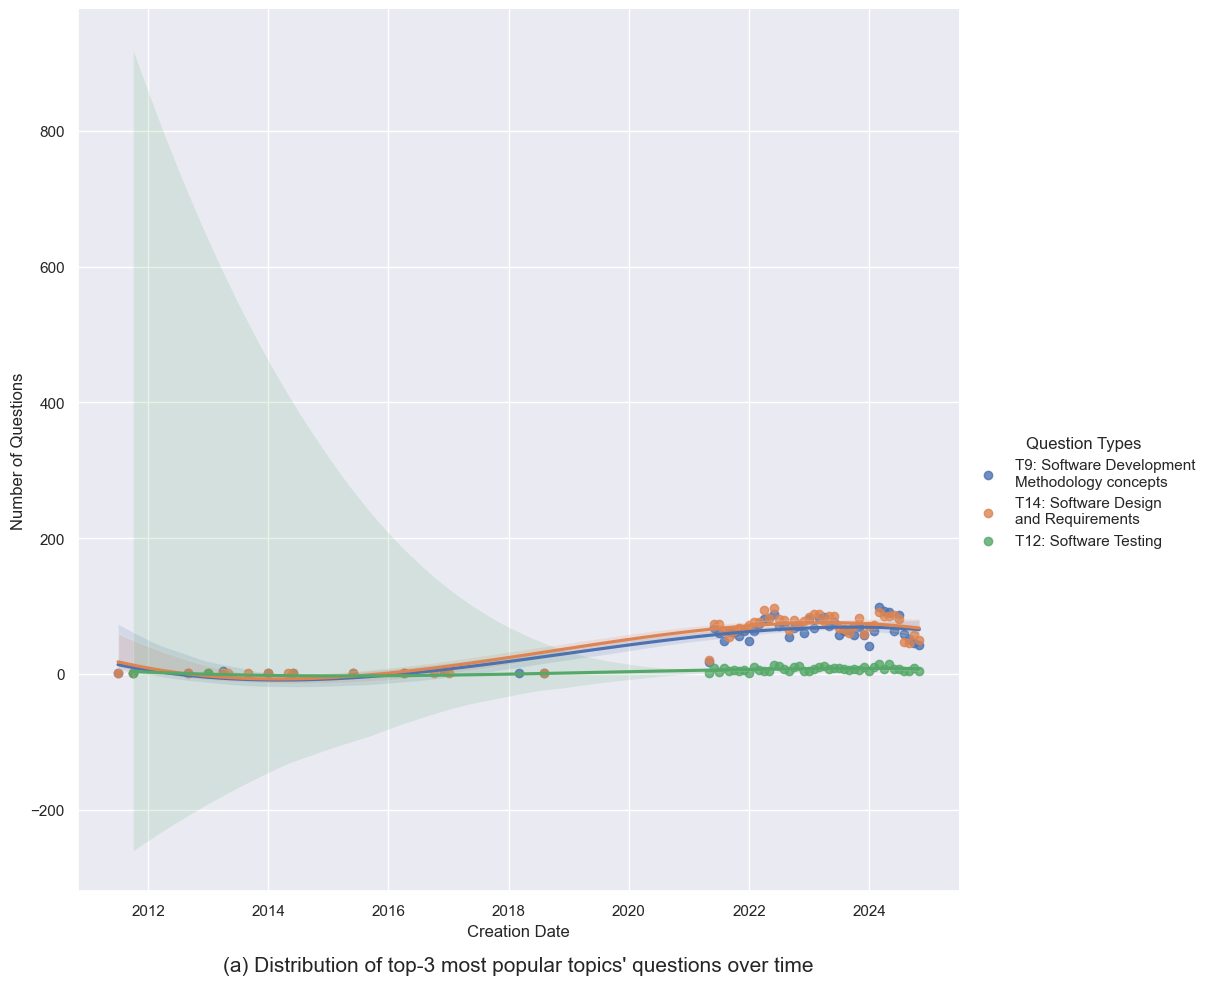

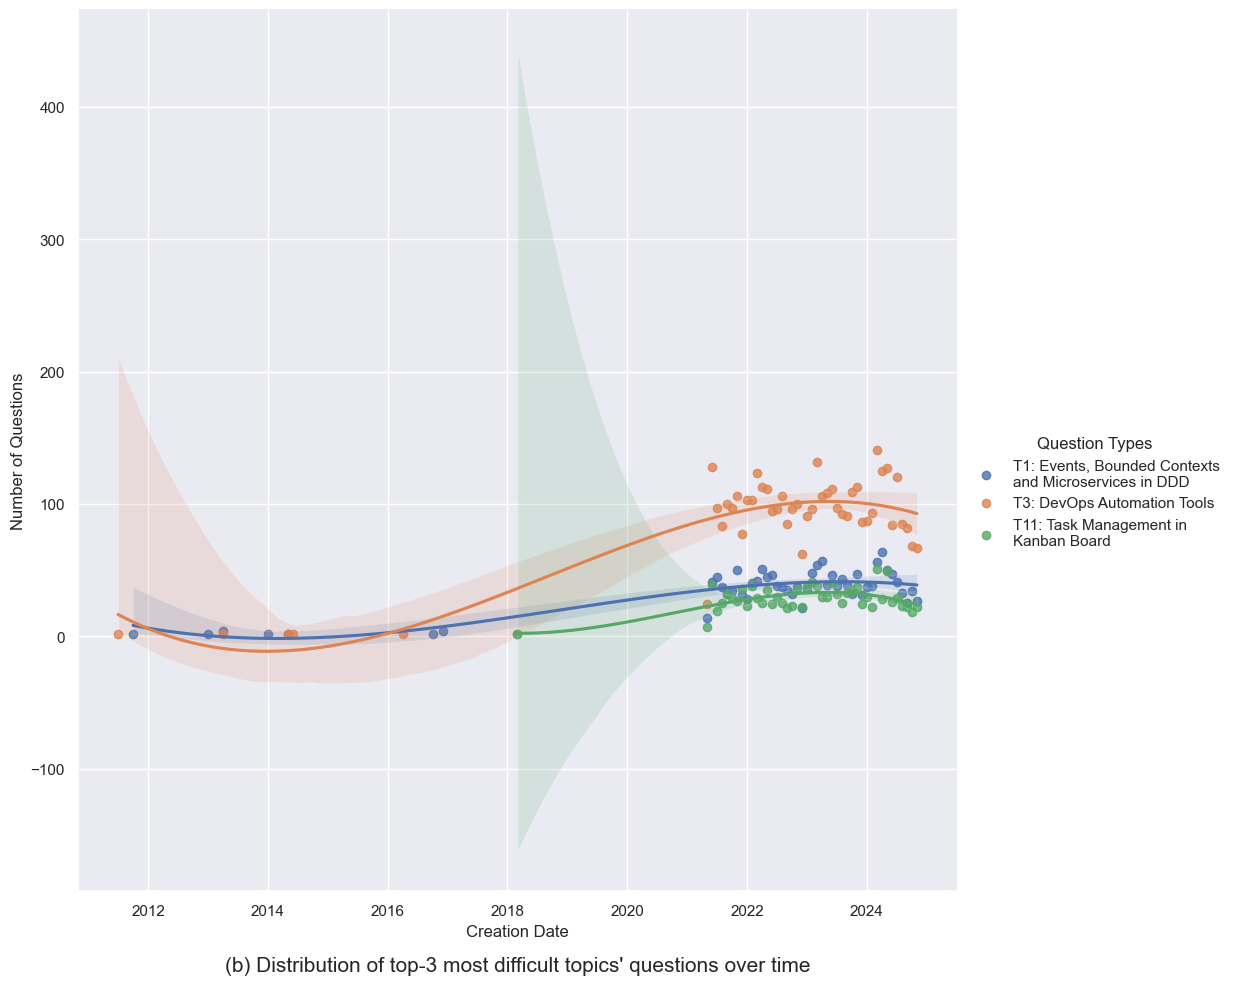

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


topicsText = [
    'T0: Continues Integration, Build and Deployment',
    'T1: Events, Bounded Contexts\nand Microservices in DDD',
    'T2: Domain model, Design patterns and layers in DDD',
    'T3: DevOps Automation Tools',
    'T4: Project, Team and Time Management',
    'T5: Team Roles’ Responsibility in Scrum',
    'T6: Project Managers’ Responsibility and Contract Management',
    'T7: Entities, Value Objects and Aggregates in DDD',
    'T8: Tools and Plugins in Agile Software Development',
    'T9: Software Development\nMethodology concepts',
    'T10: Meetings in Agile Team',
    'T11: Task Management in\nKanban Board',
    'T12: Software Testing',
    'T13: Story Estimation in Scrum Sprint',
    'T14: Software Design\nand Requirements',
    'T15: Software Development',
    'T16: Project Management',
    'T17: Team Management',
    'T18: HA',
    'T19: HB',
]


def topics_trend():
    documents = pd.read_csv('data2/topics/data_with_topics.csv')
    documents = documents.sort_values(by='CreationDate')
    topics_documents = []
    topics_documents_draw = []
    topics_documents_count = []
    for num in range(20):
        topics_documents.append(pd.DataFrame(columns=documents.columns))
        topics_documents_count.append(0)
    for index, row in documents.iterrows():
        topics = row['topics']
        topics = map(lambda x: int(x.split(', ')[0]), topics[2: len(topics) - 2].split('), ('))
        for topic in topics:
            topics_documents[topic].loc[len(topics_documents[topic].index)] = row
            topics_documents_count[topic] += 1
    for num in range(20):
        topics_documents_draw.append(get_draw_documents(topics_documents[num], topicsText[num]))
    print(topics_documents_count)
    for num in range(20):
        topics_documents[num].to_csv('data2/findings/trend/documents' + str(num) + '.csv', index=0)

    for num in range(20):
        sns.set_theme()
        sns.lmplot(
            data=topics_documents_draw[num], order=3,
            x="Creation Date", y="Number of Questions",
            height=10,
        )
        plt.title('Topic' + str(num) + ': Distribution of Questions over Time', loc='left')
        plt.subplots_adjust(top=0.95)
        plt.savefig('data2/findings/trend/image/' + str(num) + '.png')
        plt.show()

    popularity_top_3 = pd.concat([topics_documents_draw[9], topics_documents_draw[14], topics_documents_draw[12]])
    sns.set_theme()
    sns.lmplot(
        data=popularity_top_3, order=3,
        x="Creation Date", y="Number of Questions", hue="Question Types",
        height=10,
    )
    plt.title('(a) Distribution of top-3 most popular topics\' questions over time', loc='center', y=-0.1, fontsize=15)
    plt.subplots_adjust(bottom=0.1)
    plt.savefig('data2/findings/trend/image/popularity.png')
    plt.show()

    difficulty_top_3 = pd.concat([topics_documents_draw[1], topics_documents_draw[3], topics_documents_draw[11]])
    sns.set_theme()
    sns.lmplot(
        data=difficulty_top_3, order=3,
        x="Creation Date", y="Number of Questions", hue="Question Types",
        height=10,
    )
    plt.title('(b) Distribution of top-3 most difficult topics\' questions over time', loc='center', y=-0.1, fontsize=15)
    plt.subplots_adjust(bottom=0.1)
    plt.savefig('data2/findings/trend/image/difficulty.png')
    plt.show()


def get_draw_documents(documents, type):
    date = documents.iloc[0]['CreationDate'][0:7]
    date_count = 0
    df = pd.DataFrame(columns=['Creation Date', 'Number of Questions', 'Question Types'])
    for index, row in documents.iterrows():
        if row['CreationDate'][0:7] == date:
            date_count += 1
        else:
            df.loc[len(df.index)] = {'Creation Date': float(date[0:4]) + (int(date[5:7]) - 1) / 12, 'Number of Questions': date_count, 'Question Types': type}
            date = row['CreationDate'][0:7]
            date_count = 1
    df.loc[len(df.index)] = {'Creation Date': float(date[0:4]) + (int(date[5:7]) - 1) / 12, 'Number of Questions': date_count, 'Question Types': type}
    return df


topics_trend()


# popularity


In [78]:
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

def calculate_popularity(documents_path):
    documents = pd.read_csv(documents_path)
    topics_popularity = {}
    for index, row in documents.iterrows():
        topics = row['topics']
        topics = map(lambda x: x.split(', ')[0], topics[2: len(topics) - 2].split('), ('))
        for topic in topics:
            if topics_popularity.get(topic) is None:
                topics_popularity[topic] = {}
            if topics_popularity[topic].get('avg_view') is None:
                topics_popularity[topic]['avg_view'] = 0
            if topics_popularity[topic].get('avg_score') is None:
                topics_popularity[topic]['avg_score'] = 0
            if topics_popularity[topic].get('avg_fav') is None:
                topics_popularity[topic]['avg_fav'] = 0
            if topics_popularity[topic].get('avg_comment') is None:
                topics_popularity[topic]['avg_comment'] = 0
            if topics_popularity[topic].get('count') is None:
                topics_popularity[topic]['count'] = 0
            topics_popularity[topic]['avg_view'] += row['ViewCount']
            topics_popularity[topic]['avg_score'] += row['Score']
            topics_popularity[topic]['avg_fav'] += (0 if np.isnan(row['FavoriteCount']) else row['FavoriteCount'])
            topics_popularity[topic]['avg_comment'] += row['CommentCount']
            topics_popularity[topic]['count'] += 1
    for key, value in topics_popularity.items():
        topics_popularity[key]['avg_view'] /= topics_popularity[key]['count']
        topics_popularity[key]['avg_score'] /= topics_popularity[key]['count']
        topics_popularity[key]['avg_fav'] /= topics_popularity[key]['count']
        topics_popularity[key]['avg_comment'] /= topics_popularity[key]['count']
    for key, value in topics_popularity.items():
        topics_popularity[key]['popularity'] = get_geometric_mean([topics_popularity[key]['avg_view'], topics_popularity[key]['avg_score'], topics_popularity[key]['avg_fav'], topics_popularity[key]['avg_comment']])
    get_normalized_value(topics_popularity, 'popularity')
    rows = []
    for key, value in topics_popularity.items():
        value['topic_distribution'] = key
        rows.append(value)
    df = pd.DataFrame(rows)
    df.to_csv('data2/findings/popularity_difficulty/popularity.csv', index=0)
    return df


def calculate_difficulty(documents_path):
    documents = pd.read_csv(documents_path)
    topics_difficulty = {}
    for index, row in documents.iterrows():
        topics = row['topics']
        topics = map(lambda x: x.split(', ')[0], topics[2: len(topics) - 2].split('), ('))
        for topic in topics:
            if topics_difficulty.get(topic) is None:
                topics_difficulty[topic] = {}
            if topics_difficulty[topic].get('sum_answer') is None:
                topics_difficulty[topic]['sum_answer'] = 0
            if topics_difficulty[topic].get('sum_accept_answer') is None:
                topics_difficulty[topic]['sum_accept_answer'] = 0
            if topics_difficulty[topic].get('sum_views') is None:
                topics_difficulty[topic]['sum_views'] = 0
            if topics_difficulty[topic].get('receive_answer_time') is None:
                topics_difficulty[topic]['receive_answer_time'] = []
            if topics_difficulty[topic].get('count') is None:
                topics_difficulty[topic]['count'] = 0
            topics_difficulty[topic]['sum_answer'] += row['AnswerCount']
            topics_difficulty[topic]['sum_accept_answer'] += (0 if np.isnan(row['AcceptedAnswerId']) else 1)
            topics_difficulty[topic]['sum_views'] += row['ViewCount']
            if not np.isnan(row['AcceptedAnswerId']):
                topics_difficulty[topic]['receive_answer_time'].append(
                    get_diff_hours(row['CreationDate'], row['AcceptedAnswerDate'])
                )
            topics_difficulty[topic]['count'] += 1
    for key, value in topics_difficulty.items():
        topics_difficulty[key]['percent_accept'] = topics_difficulty[key]['sum_accept_answer'] / topics_difficulty[key]['count']
        topics_difficulty[key]['avg_answers_views_ratio'] = topics_difficulty[key]['sum_answer'] / topics_difficulty[key]['sum_views']
        topics_difficulty[key]['receive_answer_time'].sort()
        topics_difficulty[key]['receive_answer_time'] = topics_difficulty[key]['receive_answer_time'][math.floor(len(topics_difficulty[key]['receive_answer_time']) / 2)]
        topics_difficulty[key]['percent_accept_reciprocals'] = 1 / topics_difficulty[key]['percent_accept']
        topics_difficulty[key]['avg_answers_views_ratio_reciprocals'] = 1 / topics_difficulty[key]['avg_answers_views_ratio']
    for key, value in topics_difficulty.items():
        topics_difficulty[key]['difficulty'] = get_geometric_mean([topics_difficulty[key]['percent_accept_reciprocals'], topics_difficulty[key]['receive_answer_time'], topics_difficulty[key]['avg_answers_views_ratio_reciprocals']])
    get_normalized_value(topics_difficulty, 'difficulty')
    rows = []
    for key, value in topics_difficulty.items():
        value['topic_distribution'] = key
        rows.append(value)
    df = pd.DataFrame(rows)
    df.to_csv('data2/findings/popularity_difficulty/difficulty.csv', index=0)
    return df


def draw_popularity_difficulty(file):
    popularity_df = calculate_popularity(file)
    difficulty_df = calculate_difficulty(file)
    popularity_df = popularity_df[['topic_distribution', 'popularity_normalized']]
    difficulty_df = difficulty_df[['topic_distribution', 'difficulty_normalized']]
    popularity_difficulty_df = pd.merge(popularity_df, difficulty_df, on=['topic_distribution'])
    popularity_difficulty_df.insert(popularity_difficulty_df.shape[1], 'Topics', '')
    popularity_difficulty_df.insert(popularity_difficulty_df.shape[1], 'topic_index', 0)
    for index, row in popularity_difficulty_df.iterrows():
        row['topic_index'] = int(row['topic_distribution'])
        row['Topics'] = topicsText[int(row['topic_distribution'])]
        popularity_difficulty_df.loc[index] = row
    popularity_difficulty_df = popularity_difficulty_df.sort_values(by=["topic_index"], ascending=False)
    popularity_difficulty_df.to_csv('data2/findings/popularity_difficulty/popularity_difficulty.csv', index=0)

    plt.figure(figsize=(10, 8))
    sns.set(style='darkgrid')
    plt.rcParams["axes.unicode_minus"] = False
    bar1_list = plt.barh(popularity_difficulty_df['Topics'].values.tolist(), popularity_difficulty_df['popularity_normalized'].values.tolist(), label='Popularity')
    bar2_list = plt.barh(popularity_difficulty_df['Topics'].values.tolist(), -np.array(popularity_difficulty_df['difficulty_normalized'].values.tolist()), label='Difficulty')
    # 上面的柱状图加上标签
    for bar1 in bar1_list:
        plt.text(bar1.get_x() + bar1.get_width(), bar1.get_y() + bar1.get_height() / 2, '%.2f' % bar1.get_width(), verticalalignment='center', horizontalalignment='left')
    # 下面的柱状图加上标签
    for bar2 in bar2_list:
        plt.text(bar2.get_x() + bar2.get_width(), bar2.get_y() + bar2.get_height() / 2, '%.2f' % math.fabs(bar2.get_width()), verticalalignment='center', horizontalalignment='right')
    plt.subplots_adjust(left=0.45, right=0.95, top=0.95, bottom=0.05)
    plt.title('Popularity and Difficult', loc='left')
    plt.xlabel('')
    plt.ylabel('Topics')
    plt.legend(loc=1)
    plt.xticks([-1.17, -1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00, 1.17], ['', 1.00, 0.75, 0.50, 0.25, 0.00, 0.25, 0.50, 0.75, 1.00, ''])
    plt.savefig('data2/findings/popularity_difficulty/popularity_difficulty.png')
    plt.show()



def get_diff_hours(date1, date2):
    tstamp1 = datetime.datetime.strptime(date1, '%Y-%m-%dT%H:%M:%S.%f')
    tstamp2 = datetime.datetime.strptime(date2, '%Y-%m-%dT%H:%M:%S.%f')
    if tstamp1 > tstamp2:
        td = tstamp1 - tstamp2
    else:
        td = tstamp2 - tstamp1
    td_mins = int(round(td.total_seconds() / 60))
    return td_mins


def get_normalized_value(obj, name):
    max = sys.float_info.min
    min = sys.float_info.max
    for key, value in obj.items():
        if obj[key][name] > max:
            max = obj[key][name]
        if obj[key][name] < min:
            min = obj[key][name]
    for key, value in obj.items():
        obj[key][name + '_normalized'] = (obj[key][name] - min) / (max - min)


def get_geometric_mean(arr):
    product = 1
    for val in arr:
        product *= val
    return math.pow(product, 1 / len(arr))

In [79]:
draw_popularity_difficulty('data2/topics/data_with_topics.csv')

KeyError: 'AcceptedAnswerDate'

# topics distribution

In [83]:
def topic_distribution(topics_path):
    topics = pd.read_csv(topics_path)
    topics = topics.sort_values(by='documents_count', ascending=False)
    topics.insert(topics.shape[1], 'Topics', '')
    topics.insert(topics.shape[1], 'Number of documents', 0)
    for index, row in topics.iterrows():
        row['Number of documents'] = row['documents_count']
        row['Topics'] = topicsText[row['index']]
        topics.loc[len(topics.index)] = row

    plt.figure(figsize=(10, 8))
    sns.set_theme(style="darkgrid")
    chart = sns.barplot(
        data=topics, x="Topics", y="Number of documents",
        color='#864cc0'
    )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right', fontweight='light', fontsize=12)
    plt.title('Topics Distribution', loc='left')
    plt.subplots_adjust(top=0.95, bottom=0.6)
    plt.savefig('data2/findings/topic_distribution/distribution.png')
    plt.show()

/var/folders/ys/tg4mzr093dsgjjl04f5n863c0000gn/T/ipykernel_57008/2599051097.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right', fontweight='light', fontsize=12)


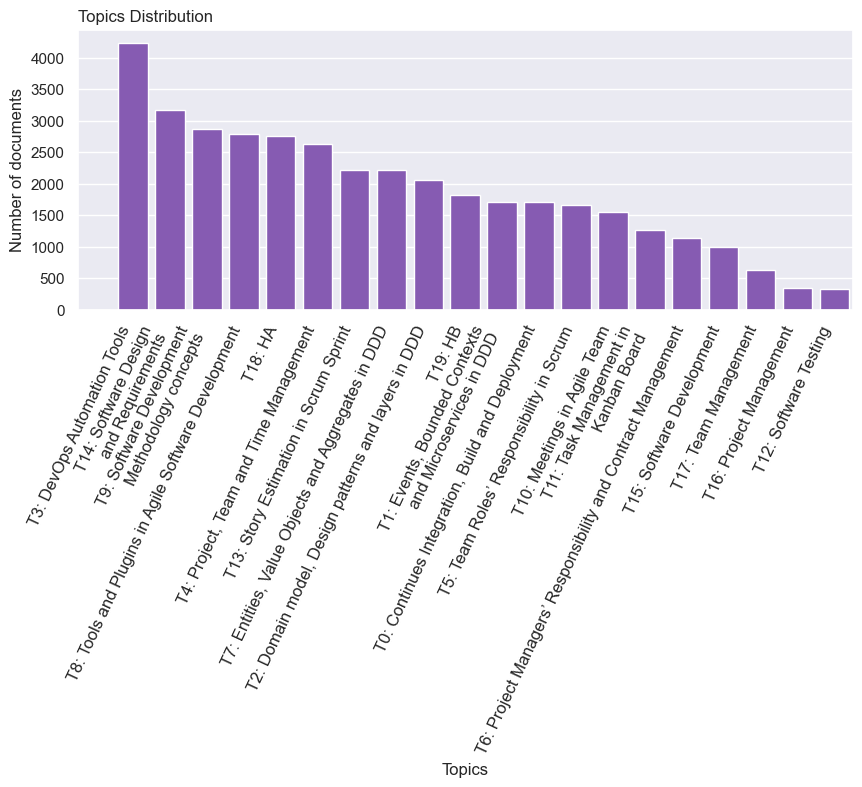

In [80]:
topic_distribution('data2/topics/topic_summary.csv')